In [ ]:
info = '''
2025.4.1
ask_obj + ask_color
实验步骤
1. SAM + Qwen 分析图像: Qwen 获取物体名称, SAM 获取物体位置信息 [此处实现第1步]

2. 混淆选项生成: 
1) mask 物体后由 Qwen 生成可能的物体名称; 
2) 框出物体后由 Qwen 生成物体颜色真值, 然后随机选择3个混淆颜色

3. target model inference: 模型回答问题, 两种提问方式. 
1) random_choice (提问n次, 每次提问时随机打乱4个选项的顺序); 
2) ordered_choice (正确答案依次放A/B/C/D进行询问)
'''

In [1]:
import json
import torch
import numpy as np

from PIL import Image, ImageDraw
from tqdm import tqdm
from datasets import load_dataset

/data/yinjinhua/envir/conda/envs/qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor

# Qwen inference function
def qwen_inference(qwen_model, qwen_processor, img, prompt, temperature, top_p, num_gen_token):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": img,
                },
                {"type": "text", 
                 "text": prompt},
            ],
        }
    ]

    # Preparation for inference
    text = qwen_processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = qwen_processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to(qwen_model.device)

    # Inference: Generation of the output
    generated_ids = qwen_model.generate(**inputs, 
                                        max_new_tokens=num_gen_token,
                                        temperature=temperature,
                                        top_p=top_p)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    output_text = qwen_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    
    return output_text[0]

2025-04-01 20:30:45.187485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 20:30:45.199067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743510645.214781  737569 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743510645.219156  737569 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743510645.230092  737569 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
import sys
from pathlib import Path
paths_to_add = [
    Path("/data/yinjinhua/NLP/5-VLLM_MIA/4-demo_segment/Grounded-SAM-2"),  # SAM 需要
    # Path("/data/yinjinhua/NLP/5-VLLM_MIA/10-demo_otherModel"),
    # Path("/data/yinjinhua/NLP/5-VLLM_MIA/target_model/VL-MIA/MiniGPT-4")
]
for custom_path in paths_to_add:
    if str(custom_path) not in sys.path:
        sys.path.append(str(custom_path)) 

In [ ]:
from sam_utli import *

In [22]:
gpu_id = 1
DEVICE = torch.device(f"cuda:{gpu_id}")

In [23]:
# get Qwen model
qwen_model_add = "/data/yinjinhua/LMmodel/Qwen_Qwen2.5-VL-7B-Instruct"
qwen_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(qwen_model_add, torch_dtype="auto", device_map=DEVICE)
qwen_processor = AutoProcessor.from_pretrained(qwen_model_add)

Loading checkpoint shards: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
# get SAM model
grounding_model, sam2_model, sam2_predictor = get_SAM_model(gpu_id)

final text_encoder_type: /data/yinjinhua/LMmodel/bert-base-uncased


In [2]:
# load dataset
def get_data(data_specific):
    used_dataset = load_dataset("/data/yinjinhua/LMdataset/VL-MIA-image", data_specific, split='train')
    # img_Flickr (600), img_Flickr_10k, img_Flickr_2k, img_dalle (592)
    dataset_length = len(used_dataset)
    # print(dataset_length) 
    return used_dataset, dataset_length

In [3]:
# get dataset
data_name = 'img_dalle' # img_Flickr, img_dalle
used_dataset, dataset_length = get_data(data_name)
len(used_dataset)

592

In [29]:
# 提供给 Qwen 分析图像的 prompt
PROMPT_obj_analysis = (
        'You are a professional image analyst. Describe images strictly following these rules:\n'
        '1. List only clearly visible main objects\n'
        '2. Use English singular noun forms\n'
        '3. Separate objects with commas, each ending with a period\n'
        '4. Order by visual significance\n'
        '5. No adjectives, colors or locations\n\n'
        'Example: person., dog., car., tree., fire hydrant.\n'
        'Answer:'
        )

In [ ]:
# 图像分析, SAM + Qwen

start_pos = 0 
end_pos = dataset_length

result = []
total_fail_index = []

for i in tqdm(range(start_pos, end_pos)):
        
    # 输出保存为 json, 其中图片用 id 指示
    current_img_id, current_img_label, current_image = i, used_dataset['label'][i], used_dataset[i]['image']
    
    max_retry = 10
    retry_count = 0
    sam_result = None
    while retry_count < max_retry:
        try:
            # Step 1: analyse image and get object name
            object_name = qwen_inference(
                qwen_model=qwen_model, 
                qwen_processor=qwen_processor, 
                img=current_image, 
                prompt=PROMPT_obj_analysis, 
                temperature=0.6, 
                top_p=0.9, 
                num_gen_token=64)
            
            object_name_refined = clean_description(object_name)

            # 如果未检测到物体 (object_name_refined 是空字符串), sam_result=None
            if not object_name_refined:
                sam_result = None
            else:
                # Step 2: SAM 分析
                sam_result = SAM_inference(sam2_predictor=sam2_predictor,
                                           grounding_model=grounding_model,
                                           here_image=current_image, 
                                           obj_name=object_name_refined)

            # 无异常时退出循环
            break

        except Exception as e:
            retry_count += 1
    
    # 超出 max_retry 仍失败的 sample
    if sam_result is None:
        total_fail_index.append(i)

    # save above infomation
    current_img_dict = dict(original_img_id=current_img_id, 
                            ground_truth_label=current_img_label,
                            object_name=object_name_refined,
                            sam_result=sam_result,
                            )
    
    # save after every image analysis
    result.append(current_img_dict)

print(len(result))

100%|██████████| 592/592 [15:49<00:00,  1.60s/it]

592


In [33]:
# 查看未能检测出物体的图片数量
print(len(total_fail_index))
print(total_fail_index)

7
[175, 237, 245, 431, 486, 497, 502]


In [35]:
# 保存结果
import os
save_add = f'img_analysis_res/{data_name}/analysis_res.json'
os.makedirs(os.path.dirname(save_add), exist_ok=True)
with open(save_add, 'w') as f:
    json.dump(result, f)

In [4]:
# 读取结果
save_add = f'img_analysis_res/{data_name}/analysis_res.json'
with open(save_add, 'r') as f:
    result = json.load(f)

len(result)

592

In [5]:
from img_utli import *

In [6]:
img_id = 0
obj_id = 0
current_image = used_dataset[img_id]['image']

In [9]:
result[img_id]['sam_result'][obj_id]

{'class_name': 'person',
 'bbox': [289.62353515625, 21.073501586914062, 387.2874755859375, 288.65625],
 'segmentation': {'size': [1024, 1024],
  'counts': 'YSU97fo04M2N3N1N2O1N2N2N2O0O2N2N2O001N2O1O1N101O1O2N1RSOmNmj0V1bTO^OYk0f0_TOB]k0i0PTOBlk0`2YOk0eVO_Kaf0T7L2L4M3M200O1O2O0O10000001N4M3M2M3M3^NQXOmJRh0i4aXOiJdg0S5h1E:G9H8N12O2M2O2N5J5L3M2O3L3M4L2N4K5L3M1O2N1O2N1O2OiJoVO?ES1Yi0UNjWO4VOd1oh0QNgYOn1Xj0N3L5K4K4L5K5K5K5K4K6J4L5K7Gfgnc0'},
 'score': [0.9417398571968079]}

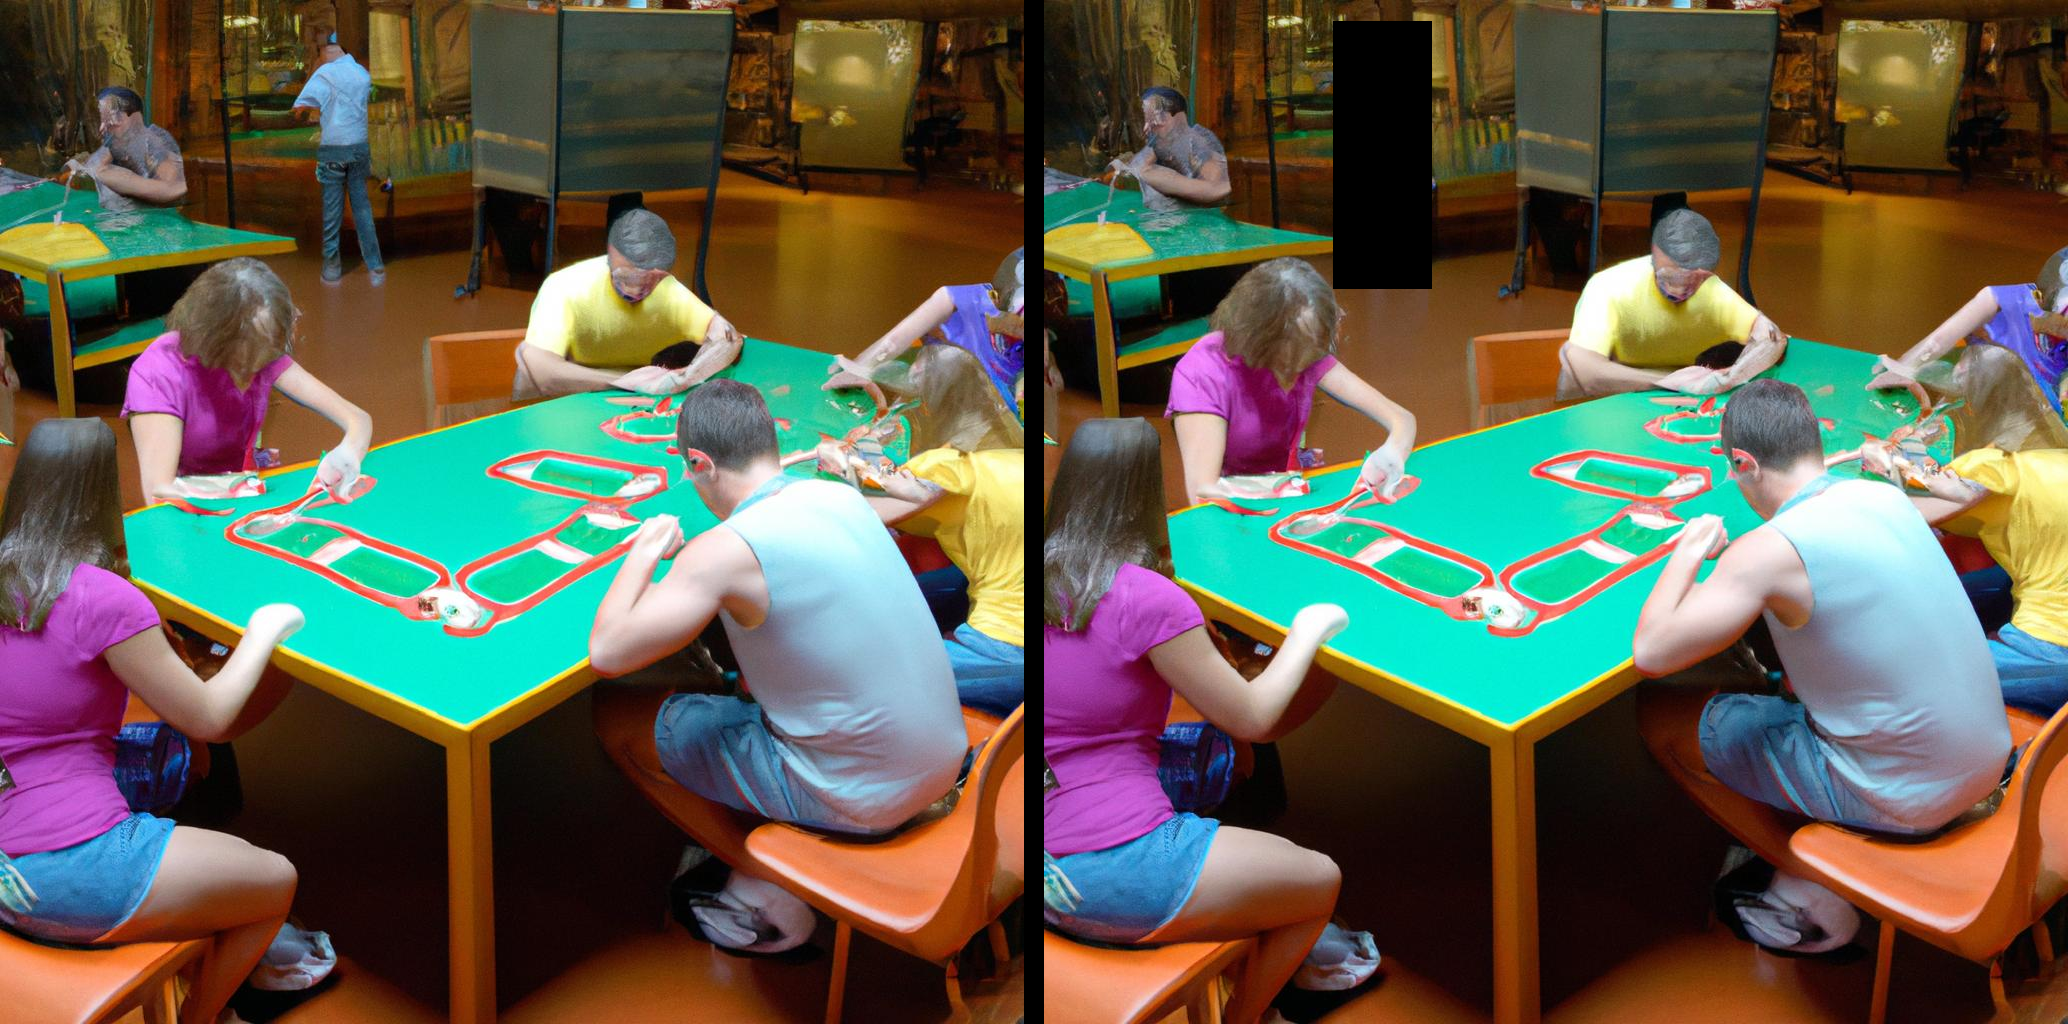

In [8]:
# 测试 box_object 函数
# image_with_box = box_object(current_image, result[img_id]['sam_result'][obj_id], box_color='red', box_width=3)
# image_with_box

# 测试 mask_object 函数
masked_image = mask_object(current_image, result[img_id]['sam_result'][obj_id])
masked_image

# 测试 concatenate_images_horizontal 函数
concatenated_image = concatenate_images_horizontal(input_images=[current_image, masked_image], dist_images=20)
concatenated_image

In [26]:
# ask_obj 生成混淆选项, 提供原图以及 mask 图, 由 Qwen 生成可能的物体名称

combined_img_obj_confuser_prompt = (
    "You are given two images:\n"
    "1. The original image.\n"
    "2. The same image with a region masked out.\n\n"

    "Additional context:\n"
    "The masked object is a '{}' in the original image.\n\n"

    "Your task:\n"
    "1. Look at both the original image and the masked image.\n"
    "2. Based on the surrounding context, propose 5 different objects that could realistically appear in the masked region.\n"
    "3. Format each object between '*'. For example, *Dog*.\n"
    "4. Do not generate any explanations.\n\n"

    "Answer:"
)

In [27]:
print(combined_img_obj_confuser_prompt.format(result[img_id]['sam_result'][obj_id]['class_name']))

You are given two images:
1. The original image.
2. The same image with a region masked out.

Additional context:
The masked object is a 'person' in the original image.

Your task:
1. Look at both the original image and the masked image.
2. Based on the surrounding context, propose 5 different objects that could realistically appear in the masked region.
3. Format each object between '*'. For example, *Dog*.
4. Do not generate any explanations.

Answer:
